### Idea:
Instead of taking all data at the same time, since that gets an acc of 60% ish, take 
each weight individually and use that

Models: 
- Deep Neuronal Network (DNN)
- Support Vector Machine (SVM)
- Decision Tree (DT)
- AdaBoost (AB)
- Random Forest (RF)
- ExtraTrees (ET)
- GradientBoosting (GB)
- Multi-Layer Perceptron (MLP)
- K-Nearest-Neighbours (KNN)
- Logistic Regression (LG)
- Linear Discriminatino Analysis (LDA)
- XGB

And then combine them all into one ensemble model

In [204]:
# extra imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import import_ipynb

# models

# DNN
# SVM
from sklearn.tree import DecisionTreeClassifier
# AB
from sklearn.ensemble import RandomForestClassifier
# ET
# GB
# MLP
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# LDA
# XGB
from sklearn.linear_model import LinearRegression

# others
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import label_binarize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Step 1: Data Processing
- read and save data
- replace empty strings with NaN
- fill empty and NaNs values with NaN
- remove draw values in Winner (they are highly unlikely to be correct)
- replace column values with usable values
- select important columns and delete the rest
- remove constant columns

In [205]:
data = pd.read_csv('../../data/data.csv')

In [206]:
data.R_Height_cms.isnull().sum()

4

In [207]:
# replace empty strings and full empty
data = data.replace(r'^\s*$', np.nan, regex=True)
data = data.fillna(np.nan)

# format data
data = data.round(3)

# percentage of draw values in data.Winner
print("Values in winner: \n" , data['Winner'].value_counts())
per = ((data["Winner"][data.Winner == "Draw"].count()) * 100 / data.shape[0])

print("\nTheres " , per , "percent of draws in the df, removing")
data = data[data.Winner != "Draw"]

print(f"Dropping {data.B_Stance.isnull().sum()} null values in B_Stance")
print(f"Dropping {data.R_Stance.isnull().sum()} null values in R_Stance")
data.dropna(subset=["R_Stance", "B_Stance"], inplace=True, axis=0)

Values in winner: 
 Red     3470
Blue    1591
Draw      83
Name: Winner, dtype: int64

Theres  1.6135303265940901 percent of draws in the df, removing
Dropping 154 null values in B_Stance
Dropping 132 null values in R_Stance


In [208]:
# transforms string/ object to int64

def getDictOfValues(data) -> dict:
    """
    Returns a dictionary of the values of the column
    """
    uniqueDict = {}
    cont = 0
    for i in data:
        if i not in uniqueDict:
            uniqueDict[i] = cont
            cont += 1
    return uniqueDict

def replaceValuesWithDict(data) -> pd.DataFrame:
    """
    Replaces the values of a column with the values of the dictionary
    """
    uniqueDict = getDictOfValues(data)

    for i in uniqueDict:
        try:
            data[data == i] = uniqueDict[i]
        except Exception as e:
            print(e)
            
    return data

toReplace = ["weight_class", "B_Stance", "R_Stance"]

for i in toReplace:
    data[i] = replaceValuesWithDict(data[i])

pd.options.mode.chained_assignment = None
data.title_bout = label_binarize(data.title_bout, classes = data.title_bout.unique())
data.Winner = label_binarize(data.Winner, classes = data.Winner.unique())



In [209]:
importantCols = np.array([4,2,1,6,8,10,11,12,37,38,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,104,105,130,132,133,134,135,136,137,138,139,140,141,142,143,144,145]) - 1
data = data.iloc[:,importantCols]

In [210]:
print("None important columns deleted, new shape: " , data.shape)

None important columns deleted, new shape:  (4806, 43)


In [211]:
print("Initial shape:", data.shape)
def remove_constant_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]
data = data.drop(remove_constant_value_features(data), axis=1)
print("After removing constant value features:", data.shape)

Initial shape: (4806, 43)
After removing constant value features: (4806, 41)


In [212]:
# get percent missing in columns
missing = round(data.isnull().sum()/data.shape[0]*100,2)
print(f'\n% Missing in {len(missing[missing > 0])} Features:\n{missing[missing > 0]}')


% Missing in 6 Features:
B_Height_cms     0.04
B_Reach_cms     12.90
B_Weight_lbs     0.04
R_Reach_cms      5.87
B_age            3.16
R_age            1.00
dtype: float64


In [213]:
print(f"Replacing {data.B_Height_cms.isnull().sum()} values in B_Height_cms with the median value")
data.B_Height_cms = data.B_Height_cms.fillna(value=data.B_Height_cms.median())
print(f"Replacing {data.R_Height_cms.isnull().sum()} values in R_Height_cms with the median value")
data.R_Height_cms = data.R_Height_cms.fillna(value=data.R_Height_cms.median())

Replacing 2 values in B_Height_cms with the median value
Replacing 0 values in R_Height_cms with the median value


In [214]:
f_hei = list(pd.concat([data["B_Height_cms"], data["R_Height_cms"]]))
f_rea = list(pd.concat([data["B_Reach_cms"], data["R_Reach_cms"]]))
f_wei = list(pd.concat([data["B_Weight_lbs"], data["R_Weight_lbs"]]))
f_measures = pd.DataFrame(data = {"height": f_hei, "reach": f_rea, "weight": f_wei})
f_measures.dropna(inplace=True)

Correlation map between height, reach and weight


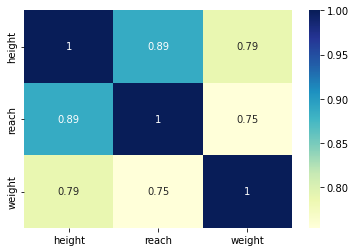

In [215]:
print("Correlation map between height, reach and weight")  
corr = f_measures.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap="YlGnBu")
plt.show()


In [216]:
print("Predicting reach based on height using linear regression")
X = f_measures["height"].values.reshape(-1, 1)
y = f_measures["reach"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)

def predict_with_lr(arr):
    return model.predict(np.array(arr.tolist()).reshape(-1,1))

data["R_Reach_cms"][pd.isna(data["R_Reach_cms"])] = predict_with_lr(data[pd.isna(data["R_Reach_cms"])]["R_Height_cms"])
data["B_Reach_cms"][pd.isna(data["B_Reach_cms"])] = predict_with_lr(data[pd.isna(data["B_Reach_cms"])]["B_Height_cms"])
            

Predicting reach based on height using linear regression


In [217]:
missing = round(data.isnull().sum()/data.shape[0]*100,2)
print(f'\n% Missing in {len(missing[missing > 0])} Features:\n{missing[missing > 0]}')


% Missing in 3 Features:
B_Weight_lbs    0.04
B_age           3.16
R_age           1.00
dtype: float64


In [218]:
print(f"Dropping the rest of null values in df, new shape: {data.shape}")

Dropping the rest of null values in df, new shape: (4806, 41)


In [220]:
# shufle data
data = data.sample(frac=1).reset_index(drop=True)
print("Shuffled data")

Shuffled data


In [223]:
print("saving 5% of data for testing and the rest for training")
test = data.iloc[:int(data.shape[0]*0.05),:]
train = data.iloc[int(data.shape[0]*0.05):,:]

saving 5% of data for testing and the rest for training


In [230]:
print(f"Final shape of df: {data.shape}")
print(f"Saving {test.shape} for testing and {train.shape} for training")

test.to_csv("../../data/test.csv", index=False)
train.to_csv("../../data/train.csv", index=False)

Final shape of df: (4806, 41)
Saving (240, 41) for testing and (4566, 41) for training


# Step 2: EDA and Data Visualization

# Setp 3: Modeling